In [1]:
!pip install pmdarima

In [2]:
import os
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [3]:
dateparse = lambda dates: pd.to_datetime(dates, '%Y-%m-%d')
df=pd.read_csv('MSFT.csv',index_col='Date',parse_dates=['Date'])
df=df.dropna()

FileNotFoundError: [Errno 2] No such file or directory: 'MSFT.csv'

In [4]:
df

NameError: name 'df' is not defined

NameError: name 'df' is not defined

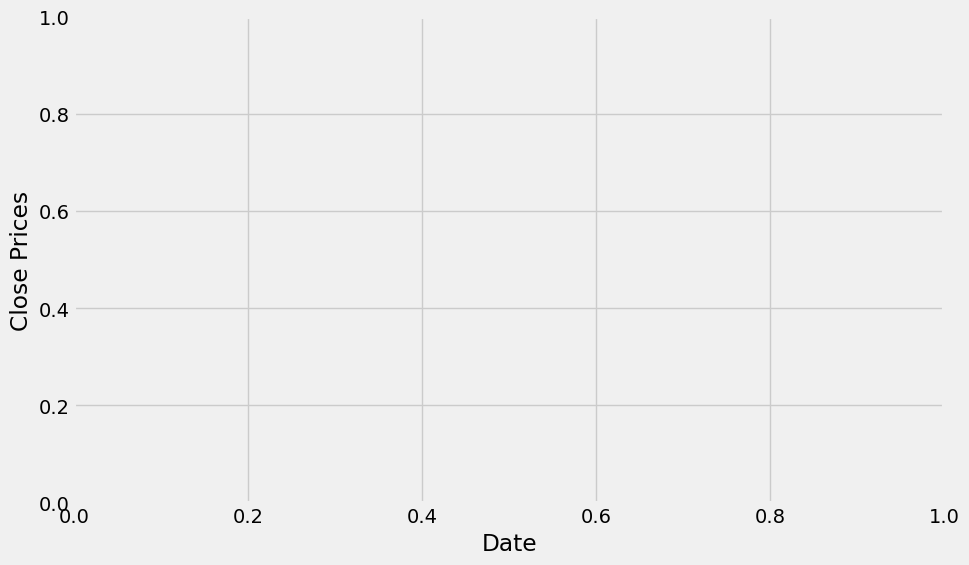

In [5]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(df['Close'])
plt.title('MICROSOFT closing price')
plt.show()

In [6]:
df['Close'].plot(kind='kde');

NameError: name 'df' is not defined

In [ ]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of ADF test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for adft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(df['Close'])

In [ ]:
result = seasonal_decompose(df['Close'],model='multiplicative',period=30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

In [ ]:
#if not stationary then eliminate trend
#Eliminate trend
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df['Close'])
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

In [ ]:
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.8)], df_log[int(len(df_log)*0.8):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

In [ ]:
stepwise_fit = auto_arima(train_data,
                          start_p=0,
                          start_q=0,
                          test='adf',
                          max_p=3,
                          max_q=3,
                          m=1,
                          d=None,
                          seasonal=False,
                          start_P=0,
                          D=0,
                          trace=True,
                          error_action='ignore',
                          suppress_warnings=True,
                          stepwise=True)

stepwise_fit.summary()
stepwise_fit.plot_diagnostics(figsize=((15,6)))
plt.show()

In [ ]:
model = ARIMA(train_data,order=(3,1,0))
fitted = model.fit()
print(fitted.summary())

In [ ]:
y_pred = fitted.get_forecast(len(test_data.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = fitted.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test_data.index
y_pred_out = y_pred_df["Predictions"] 
plt.figure(figsize=(10,6))
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.plot(y_pred_out, color='Yellow', label = 'ARIMA Predictions')
plt.legend()

In [ ]:
fc = fitted.forecast(30,alpha=0.05)
fc

In [ ]:
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)
#lower_series = pd.Series(conf[:, 0], index=test_data.index)
#upper_series = pd.Series(conf[:, 1], index=test_data.index)
# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training data')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
#plt.fill_between(lower_series.index, lower_series, upper_series, 
#                 color='k', alpha=.10)
plt.title('MICROSOFT Stock Close Price Prediction')
plt.xlabel('Time')
plt.ylabel('ARCH CAPITAL GROUP Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [ ]:
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))